<a href="https://colab.research.google.com/github/EsamSharaf/Online-Payment-Fraud-Detection/blob/main/Copy_of_Online_PaymentFraud_Detaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Intro**

**The dataset contains samples of online payments with Fraud/ not Fraud labels. To enhance  detecting Fraudulent transactions, Logistic Regression Model implemented. The dataset shows that only 16 out of 8213 fraud transactions was correctly detected (0.002 recall rate). The ML model is built to improve the ability for detection (higher recall).**

**The provided variables as follows:**

**1. step: represents a unit of time where 1 step equals 1 hour (int).**

**2. type: type of online transaction (PAYMENT, TRANSFER, CASH_OUT, CASH_IN, DEBIT) (categorical).**

**3. amount: the amount of the transaction (float).**

**4. nameOrig: customer starting the transaction (str).**

**5. oldbalanceOrg: balance before the transaction (float).**
    
**6. newbalanceOrig: balance after the transaction (float).**
    
**7. nameDest: recipient of the transaction (str).**

**8. oldbalanceDest: initial balance of recipient before the transaction (float).**

**9. newbalanceDest: the new balance of recipient after the transaction (float).**
    
**10. isFraud: fraud transaction (1) or not (0) - target label (int).**

**11. isFraudFlagged: fraud transaction detected (1) or not (0) (int).**  

**The outcome of this implementation increases the ability to detect fraudulent samples from 0.002 to ~0.7543 recall rate.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, roc_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

# **Helper Functions**

In [ ]:
#user define function to plot PR & ROC curves
def plot_results(pipeline, X_test, Y_test, Y_pred, clf_name: str):
  precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)
  print('Precision: {:.4f}'.format(precision[1]), "---", 'Recall: {:.4f}'.format(recall[1]))
  print('\n')

  auc = metrics.roc_auc_score(Y_test, Y_pred)
  false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(Y_test, Y_pred)
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))
  fig.tight_layout(pad=5.0)

  #plot PR curve
  PrecisionRecallDisplay.from_estimator(pipeline, X_test, Y_test, ax= ax1, name=clf_name)
  
  #plot AUC-ROC curve
  ax2.set_xlim(0, 1)
  ax2.set_ylim(0, 1)
  ax2.set_title("AUC & ROC Curve")
  ax2.plot(false_positive_rate, true_positive_rate, 'g')
  ax2.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
  ax2.text(0.6, 0.05, 'AUC = %0.4f' % auc, fontdict={'size':12, 'weight':'bold', 'color':'blue'})
  ax2.set_xlabel("False Positive Rate")
  ax2.set_ylabel("True Positive Rate")

**Importing the dataset**

In [ ]:
# Import the dataset
df = pd.read_csv("drive/My Drive/Colab Notebooks/datasets/PS_20174392719_1491204439457_log.csv")

# **Exploratory Data Analysis (EDA)**

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# Count how many samples have successfully detected
df.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [ ]:
# Count how many fraudulent samples in the dataset
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

**The initial success - before applying ML model-  to capture fraudlant samples = 16 / 8213 ~= 0.002**

In [ ]:
# Check any missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**No missing Values**

In [ ]:
df.describe()

In [ ]:
# Plot classes precentage in the dataset
import plotly.express as px

fig = px.pie(df,
            values = df.isFraud.value_counts().to_numpy(),
            names = df.isFraud.value_counts().index,
            hole = 0.4,
            title = "Fraud (1) / Not Fraud (0) Label Distribution")
fig.show()

**The dataset suffers from high degree of skewness to the negative class (unfraud transaction). less than 1% of smaples are positive.**

In [ ]:
# Plot the distribution of 'type' feature in the dataset 
type_transaction = df["type"].value_counts()
transaction = type_transaction.index
quantity = type_transaction.values

# plotting pie chart
fig = px.pie(df,
            values = quantity,
            names = transaction, 
            hole = 0.4,
            title = "Distribution of Transaction Type")
fig.show()

**Plotting Fraud Transcations for each transaction type**

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

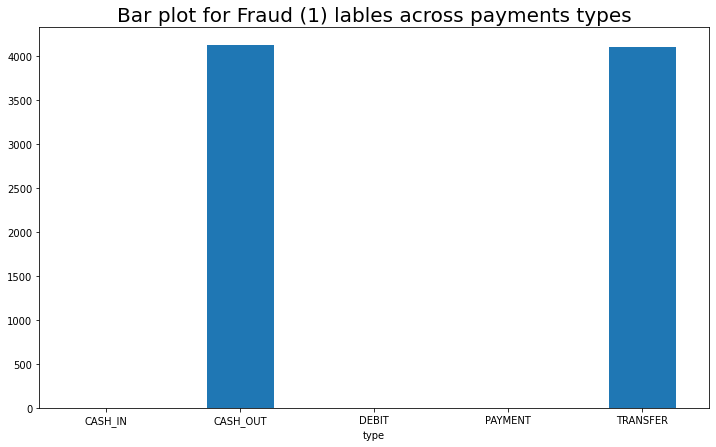

In [ ]:
#Plot bar chart to get insights of fraudulent trans. for each trans. type 
from matplotlib.ticker import ScalarFormatter

df_for_sctacked_bar = df.groupby(['type'])['isFraud'].sum()
df_for_sctacked_bar.plot(kind='bar', stacked=False, figsize=(12,7))

#Add a title and rotate the x-axis labels to be horizontal.
plt.title('Bar plot for Fraud (1) lables across payments types', fontdict={'fontsize': 20})
plt.xticks(rotation=0, ha='center')

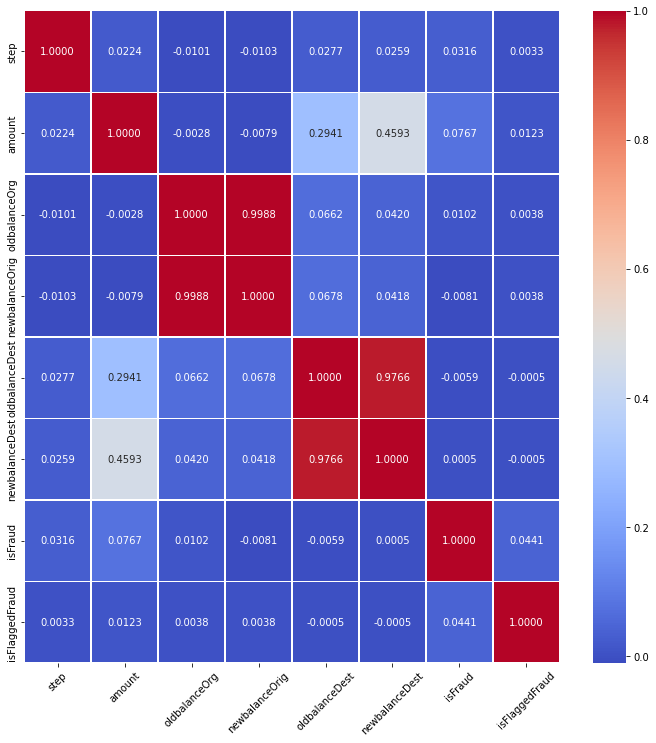

In [ ]:
# Plot heatmap based on Pearson's correlation
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(method ='pearson'),annot=True,linewidth=0.5,fmt="0.4f", cmap = 'coolwarm')
plt.xticks(rotation=45)
plt.show()

**- The target feature (IsFraud) has no linear correlation with any independent variable.**

**- There is very strong corr. between "newbalanceOrigin" and "oldbalanceOrg", also, a very strong relationship between "oldbalanceDest" and "newbalanceDest"**.

**- "amount" feature has moderate correlation with "newbalanceDest".**

**Applying Chi-Square test to find is there a significant relationship between categorical variables and the target variable**

In [ ]:
# store columns with specific data type
integer_columns = df.select_dtypes(include=['int64']).columns
float_columns = df.select_dtypes(include=['float64']).columns
object_columns = df.select_dtypes(include=['object']).columns

In [ ]:
categorical_feats_list = object_columns.tolist()

In [ ]:
categorical_feats_list

['type', 'nameOrig', 'nameDest']

**Both "nameDest" and "NameOrig" to get removed because it has no meaning. They are anonymous for customers' names.**

In [ ]:
categorical_feats_list = [ele for ele in categorical_feats_list \
                          if ele != 'nameOrig' and ele != 'nameDest']

In [ ]:
categorical_feats_list

['type']

In [ ]:
# Chi^2 test isFraud and step features
#from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency

for elem in categorical_feats_list:

  contingency_table = pd.crosstab(df.isFraud, df[elem], margins=True)
  stat, p, dof, expected = chi2_contingency(contingency_table)
  print(f'\n P-value for "{elem}" = {p}')
  #scores, pvalues = chi2(np.array(df.step).reshape(-1, 1) , np.array(df.isFraud).reshape(-1, 1))
  #print(f'\n p value using chi^2 =  {pvalues}')


 P-value for "type" = 0.0


**The test shows signficant relationship between all categorical variable with "type" feature based on p-value=0.05**

**Applying t-test between each numerical variable and the target variable**

In [ ]:
numerical_feats_list = integer_columns.tolist() + float_columns.tolist()
numerical_feats_list

['step',
 'isFraud',
 'isFlaggedFraud',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [ ]:
numerical_feats_list = [ele for ele in numerical_feats_list if ele != 'isFraud']

In [ ]:
numerical_feats_list

['step',
 'isFlaggedFraud',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [ ]:
from scipy.stats import ttest_ind

for elem in numerical_feats_list:
  score = ttest_ind(df[elem][df['isFraud'] == 0],df[elem][df['isFraud'] == 1])
  print('----------------------------')
  print(f't-test for "{elem}": \n')
  print(' statistic score = {:.2f}'.format(score.statistic))
  print(' pvalue = ', score.pvalue)
  

----------------------------
t-test for "step": 

 statistic score = -79.69
 pvalue =  0.0
----------------------------
t-test for "isFlaggedFraud": 

 statistic score = -111.37
 pvalue =  0.0
----------------------------
t-test for "amount": 

 statistic score = -194.01
 pvalue =  0.0
----------------------------
t-test for "oldbalanceOrg": 

 statistic score = -25.62
 pvalue =  1.0542893553023227e-144
----------------------------
t-test for "newbalanceOrig": 

 statistic score = 20.55
 pvalue =  7.168312431103147e-94
----------------------------
t-test for "oldbalanceDest": 

 statistic score = 14.85
 pvalue =  7.463206943535623e-50
----------------------------
t-test for "newbalanceDest": 

 statistic score = -1.35
 pvalue =  0.17689674407002928


**- Based on the t-test results with critical value (P-value) = 0.05, isFraud feature has significant dependency on "amount", "oldbalanceOrg", "newbalanceOrig", and "oldbalanceDest" features.**

**- t-test indicates no significant association between "isFraud" feature and "newbalanceDest" feature.**

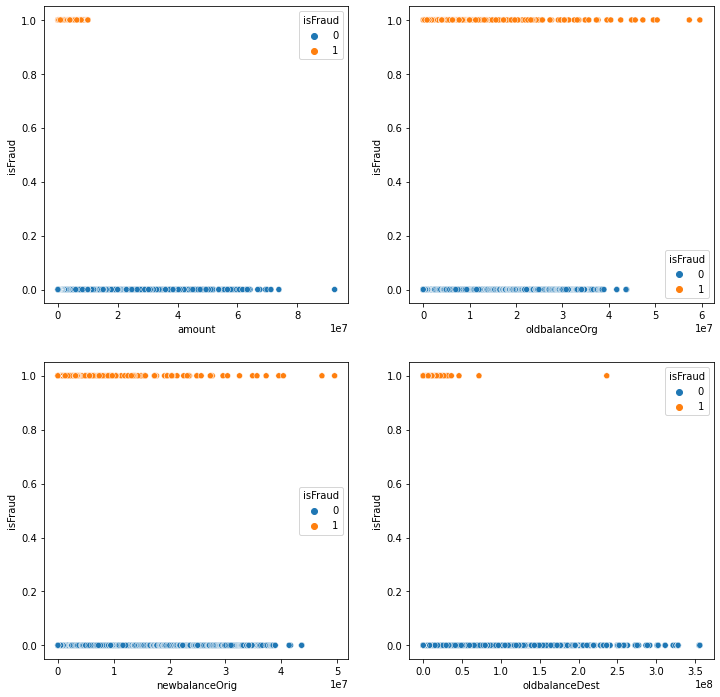

In [ ]:
fig, axes = plt.subplots(2, 2, squeeze=False, figsize=(12, 12))
sns.scatterplot(data=df, x='amount', y='isFraud', ax=axes[0, 0], hue = "isFraud")
sns.scatterplot(data=df, x='oldbalanceOrg', y='isFraud', ax=axes[0, 1], hue = "isFraud")
sns.scatterplot(data=df, x='newbalanceOrig', y='isFraud', ax=axes[1, 0], hue = "isFraud")
sns.scatterplot(data=df, x='oldbalanceDest', y='isFraud', ax=axes[1, 1], hue = "isFraud")

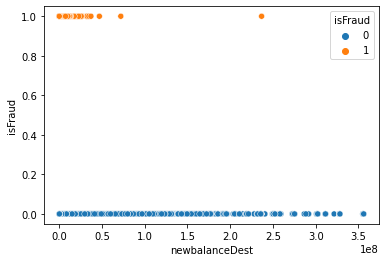

In [ ]:
sns.scatterplot(x=df['newbalanceDest'], y=df['isFraud'], hue = df["isFraud"])

**The motivation of previous plotings is to visualize the nature of the relationship between the target variable and each numeric variable. It shows nonlinear seperable problem**

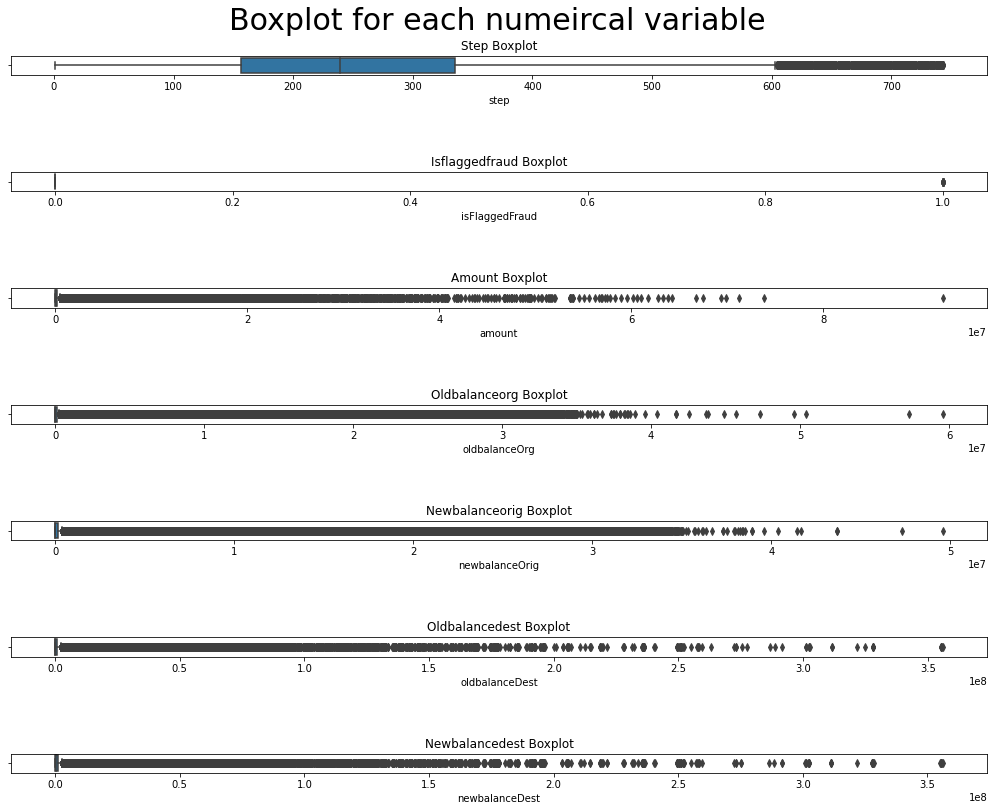

In [ ]:
#Plot boxplot for each numeric variable
fig_rows, fig_cols  = len(numerical_feats_list), 1
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(15, 12))
fig.suptitle('Boxplot for each numeircal variable', fontsize=30)
for indx, elem in enumerate(numerical_feats_list):
  sns.boxplot(x=df[elem], orient="h", ax=axes[indx])
  axes[indx].set_title(f'{numerical_feats_list[indx].title()} Boxplot')
plt.tight_layout(pad=5.0)

# **Data Pre-processing**

In [ ]:
cat_transformer = Pipeline([('cat_encoder', OrdinalEncoder(dtype=np.int64))])

In [ ]:
num_transformer = Pipeline([('robust_scalar', RobustScaler())])

In [ ]:
# Creating preprocessing pipeline
preprocessing = make_column_transformer((cat_transformer, categorical_feats_list),\
                                        (num_transformer, numerical_feats_list)\
                                        , remainder='passthrough')

In [ ]:
# Drop nameOrig and nameDest features and the target label from the set of independent variables 
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis = 1)
Y = df['isFraud'].to_numpy()

**- Both "nameDest" and "NameOrig" dropped because it has no meaning. They are anonymous for customers' names.**

In [ ]:
# Check the feature matrix after the preprocessing(i.e model input)
preprocess_output = pd.DataFrame(preprocessing.fit_transform(X),\
                                 columns= preprocessing.transformers_[0][2] +\
                                 preprocessing.transformers_[1][2])
preprocess_output

,type,step,isFlaggedFraud,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,3.0,-1.329609,0.0,-0.332932,1.452991,1.111175,-0.140722,-0.193057
1,3.0,-1.329609,0.0,-0.373762,0.065610,0.134375,-0.140722,-0.193057
2,4.0,-1.329609,0.0,-0.382380,-0.130708,0.000000,-0.140722,-0.193057
3,1.0,-1.329609,0.0,-0.382380,-0.130708,0.000000,-0.118260,-0.193057
4,3.0,-1.329609,0.0,-0.323571,0.254820,0.207169,-0.140722,-0.193057
...,...,...,...,...,...,...,...,...
6362615,1.0,2.815642,0.0,1.355693,3.032881,0.000000,-0.140722,0.112438
6362616,4.0,2.815642,0.0,31.927899,58.679504,0.000000,-0.140722,-0.193057
6362617,1.0,2.815642,0.0,31.927899,58.679504,0.000000,-0.068096,5.544730
6362618,4.0,2.815642,0.0,3.968274,7.788223,0.000000,-0.140722,-0.193057


In [ ]:
mapping = {"CASH_IN": 1, "CASH_OUT": 2, "PAYMENT": 3, "DEBIT":4, "TRANSFER":5}

**Make sure which features goes to which transformer**

In [ ]:
preprocessing.output_indices_

{'pipeline-1': slice(0, 1, None),
 'pipeline-2': slice(1, 8, None),
 'remainder': slice(0, 0, None)}

**Check-out the number of features icncluded in the preprocessing part**

In [ ]:
preprocessing.n_features_in_

8

**Mutual Information Score with the target variable**

In [ ]:
# Compute Mutual Information between features and the Target variable
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(preprocess_output, Y \
                                  , discrete_features=False, random_state = 42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = preprocessing.transformers_[0][2]+\
                    preprocessing.transformers_[1][2]
mutual_info.sort_values(ascending=False)

type              0.170712
oldbalanceDest    0.041416
newbalanceDest    0.035985
step              0.008767
oldbalanceOrg     0.006170
amount            0.002451
newbalanceOrig    0.000650
isFlaggedFraud    0.000024
dtype: float64

In [ ]:
# Compute Mutual Information between features and the Target variable
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(preprocess_output, Y \
                                  , discrete_features=[0,2], random_state = 42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = preprocessing.transformers_[0][2]+\
                    preprocessing.transformers_[1][2]
mutual_info.sort_values(ascending=False)

oldbalanceDest    0.041356
newbalanceDest    0.036097
step              0.008789
oldbalanceOrg     0.006181
amount            0.002451
type              0.001380
newbalanceOrig    0.000663
isFlaggedFraud    0.000017
dtype: float64

In [ ]:
X['type'] = X['type'].replace(mapping)
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,3,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,3,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,5,181.00,181.00,0.00,0.00,0.00,0
3,1,2,181.00,181.00,0.00,21182.00,0.00,0
4,1,3,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...
6362615,743,2,339682.13,339682.13,0.00,0.00,339682.13,0
6362616,743,5,6311409.28,6311409.28,0.00,0.00,0.00,0
6362617,743,2,6311409.28,6311409.28,0.00,68488.84,6379898.11,0
6362618,743,5,850002.52,850002.52,0.00,0.00,0.00,0


In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_info2 = mutual_info_classif(X['type'].values.reshape(-1,1), Y \
                                  , discrete_features=True, random_state = 42)
mutual_info2

array([0.0013804])

# **Splitting the data for trainning and Testing**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# **Logistic Regression Classifier without Feature Engineering**

**F1 macro precision, and recall evaluation metrics will be considered for comparing models performance because of the imbalance in the dataset.**

**LR Model 1: Dropping names since they are uninformative.**

In [ ]:
# Logestic Pipeline
from sklearn.linear_model import LogisticRegression

LR1_pipeline = Pipeline([('transformer', preprocessing), ('estimator', LogisticRegression())])
cvfolds = KFold(n_splits=5)
LR1_scores = cross_validate(LR1_pipeline.fit(X_train, Y_train), X_train, Y_train \
                            , cv = cvfolds, scoring=('f1_macro', 'accuracy', \
                            'f1_micro', 'recall', 'precision'), return_train_score=True)
LR1_scores

{'fit_time': array([50.9865973 , 55.09028339, 38.45513105, 43.21753287, 40.18343091]),
 'score_time': array([3.94157863, 2.28851867, 2.38579583, 2.56635976, 3.98247647]),
 'test_f1_macro': array([0.81228336, 0.81127669, 0.81316453, 0.81664978, 0.81455815]),
 'train_f1_macro': array([0.81601082, 0.81180188, 0.814654  , 0.81054713, 0.81271837]),
 'test_accuracy': array([0.99925836, 0.99923774, 0.99924756, 0.9992731 , 0.99926917]),
 'train_accuracy': array([0.99926254, 0.99925591, 0.99926573, 0.99924584, 0.99925026]),
 'test_f1_micro': array([0.99925836, 0.99923774, 0.99924756, 0.9992731 , 0.99926917]),
 'train_f1_micro': array([0.99926254, 0.99925591, 0.99926573, 0.99924584, 0.99925026]),
 'test_recall': array([0.48125478, 0.47446336, 0.48092745, 0.49117421, 0.48803089]),
 'train_recall': array([0.48864926, 0.47958794, 0.48363775, 0.47655955, 0.48187995]),
 'test_precision': array([0.89093484, 0.90664781, 0.8993007 , 0.89260809, 0.88639551]),
 'train_precision': array([0.89594173, 0.8927

In [ ]:
LR1_Y_pred = LR1_pipeline.predict(X_test)

Precision: 0.9041 --- Recall: 0.4772




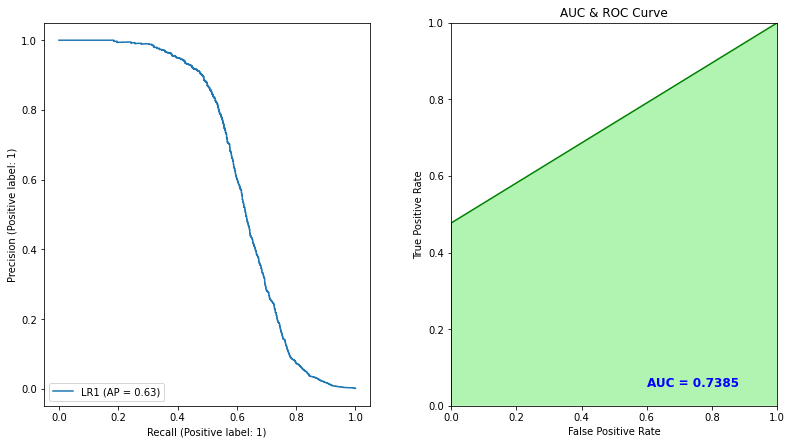

In [ ]:
plot_results(LR1_pipeline, X_test, Y_test, LR1_Y_pred, 'LR1')

**LR Model 2: Drop 'step' and 'isFlaggedFraud' features since they have no added value on the performance. Same pipeline is utilized as only X has changed.**

In [ ]:
# Drop 'step' and 'isFlaggedFraud'
X_modified = df.drop(['isFraud', 'nameOrig', 'nameDest', 'step', 'isFlaggedFraud'], axis = 1)
X_modified

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00
2,TRANSFER,181.00,181.00,0.00,0.00,0.00
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00
...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00


In [ ]:
#numerical_feats_list_mod = X_modified.loc[:, X_modified.columns!='type'].columns.tolist()  
preprocessing_mod = make_column_transformer((cat_transformer, ['type']),(num_transformer, ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']))

In [ ]:
X_train_mod, X_test_mod, Y_train_mod, Y_test_mod = train_test_split(X_modified, Y, test_size=0.2, random_state = 42)
LR2_pipeline = Pipeline([('transformer', preprocessing_mod), ('estimator', LogisticRegression())])
cvfolds = KFold(n_splits=5)
LR2_scores = cross_validate(LR2_pipeline.fit(X_train_mod, Y_train_mod), X_train_mod, Y_train_mod, cv = cvfolds, scoring=('f1_macro', 'accuracy', 'f1_micro', 'recall', 'precision'), return_train_score=True)
LR2_scores

{'fit_time': array([23.61812735, 24.41246033, 27.0656805 , 26.91049647, 25.79148412]),
 'score_time': array([2.43136239, 2.35449147, 2.34606767, 2.34638286, 2.32854319]),
 'test_f1_macro': array([0.80221352, 0.79984811, 0.80378834, 0.8071568 , 0.80455242]),
 'train_f1_macro': array([0.80558885, 0.80355586, 0.80443756, 0.8006135 , 0.80365271]),
 'test_accuracy': array([0.99922595, 0.99919746, 0.99921711, 0.99924265, 0.9992397 ]),
 'train_accuracy': array([0.99922791, 0.9992311 , 0.9992311 , 0.9992149 , 0.99922128]),
 'test_f1_micro': array([0.99922595, 0.99919746, 0.99921711, 0.99924265, 0.9992397 ]),
 'train_f1_micro': array([0.99922791, 0.9992311 , 0.9992311 , 0.9992149 , 0.99922128]),
 'test_recall': array([0.4613619 , 0.45373797, 0.46222887, 0.47198772, 0.46640927]),
 'train_recall': array([0.46821793, 0.46222816, 0.46442161, 0.4563327 , 0.46357116]),
 'test_precision': array([0.87772926, 0.88583815, 0.88793103, 0.88108883, 0.87918486]),
 'train_precision': array([0.88141026, 0.8859

In [ ]:
LR2_Y_pred = LR2_pipeline.predict(X_test_mod)

Precision: 0.8801 --- Recall: 0.4531




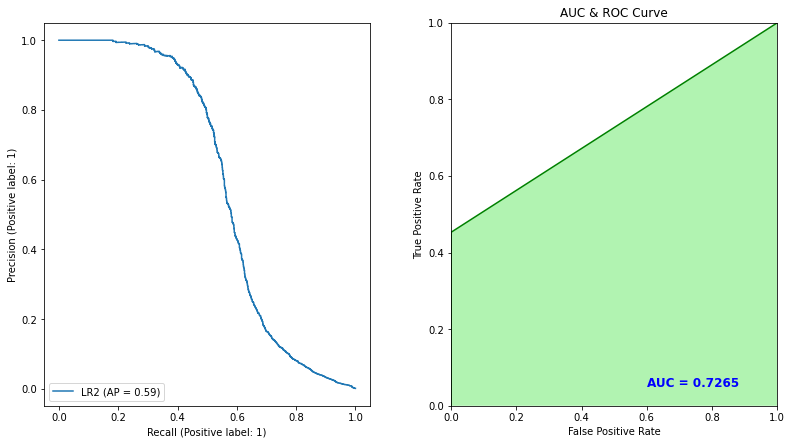

In [ ]:
plot_results(LR2_pipeline, X_test_mod, Y_test_mod, LR2_Y_pred, 'LR2')

**LR2 Model performace has slightly lower performance comparing to LR1 model which indicates that 'step'and 'isFlaggedFraud' are redundant**

# **Logistic Regression with Feature Engineering**

**LR Model 3: Creating new features - through feature engineering, which may enhance Logistic Regression performance. One feature is generated by subtracting "newbalanceOrig" from "oldbalanceOrg". Another feature is created by subtracting "newbalanceDest" from "oldbalanceDest".**

In [ ]:
# Create new feature
X_new = X.copy(deep = True)
X_new['balanceOrigDiff'] = X_new['oldbalanceOrg'] - X_new['newbalanceOrig']
X_new['balanceDestDiff'] = X_new['oldbalanceDest'] - X_new['newbalanceDest']
X_new = X_new.drop(['oldbalanceOrg', 'newbalanceOrig'], axis=1)
X_new = X_new.drop(['oldbalanceDest', 'newbalanceDest'], axis=1)

In [ ]:
X_new.head()

,step,type,amount,isFlaggedFraud,balanceOrigDiff,balanceDestDiff
0,1,PAYMENT,9839.64,0,9839.64,0.0
1,1,PAYMENT,1864.28,0,1864.28,0.0
2,1,TRANSFER,181.00,0,181.00,0.0
3,1,CASH_OUT,181.00,0,181.00,21182.0
4,1,PAYMENT,11668.14,0,11668.14,0.0


In [ ]:
numerical_feats_list_mod = X_new.loc[:, X_new.columns!='type'].columns.tolist()  
preprocessing_mod = make_column_transformer((cat_transformer, ['type']),(num_transformer, numerical_feats_list_mod))

In [ ]:
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_new, Y, test_size=0.2, random_state = 42)
numerical_feats_list_mod = X_modified.loc[:, X_modified.columns!='type'].columns.tolist()
LR3_pipeline = Pipeline([('transformer', preprocessing_mod), ('estimator', LogisticRegression())])
LR3_scores = cross_validate(LR3_pipeline.fit(X_train_new, Y_train_new), X_train_new, Y_train_new, cv = cvfolds, scoring=('f1_macro', 'accuracy', 'f1_micro', 'recall', 'precision'), return_train_score=True)
LR3_scores

{'fit_time': array([32.3980186 , 41.03952956, 43.14111185, 40.10888243, 32.73104024]),
 'score_time': array([2.38977075, 2.26445913, 2.25962853, 2.2443459 , 2.25972557]),
 'test_f1_macro': array([0.80526719, 0.80531896, 0.80280359, 0.80908612, 0.80455242]),
 'train_f1_macro': array([0.80641517, 0.80484244, 0.80660714, 0.80328382, 0.80512845]),
 'test_accuracy': array([0.99923675, 0.99921711, 0.99921318, 0.99925247, 0.9992397 ]),
 'train_accuracy': array([0.99923233, 0.99923528, 0.99924191, 0.999223  , 0.99922742]),
 'test_f1_micro': array([0.99923675, 0.99921711, 0.99921318, 0.99925247, 0.9992397 ]),
 'train_f1_micro': array([0.99923233, 0.99923528, 0.99924191, 0.999223  , 0.99922742]),
 'test_recall': array([0.46671767, 0.46336047, 0.46073298, 0.47352264, 0.46640927]),
 'train_recall': array([0.46878547, 0.46470813, 0.4663242 , 0.46181474, 0.46564741]),
 'test_precision': array([0.88405797, 0.89684814, 0.88505747, 0.8916185 , 0.87918486]),
 'train_precision': array([0.88626609, 0.8877

In [ ]:
LR3_Y_pred = LR3_pipeline.predict(X_test_new)

Precision: 0.8930 --- Recall: 0.4586




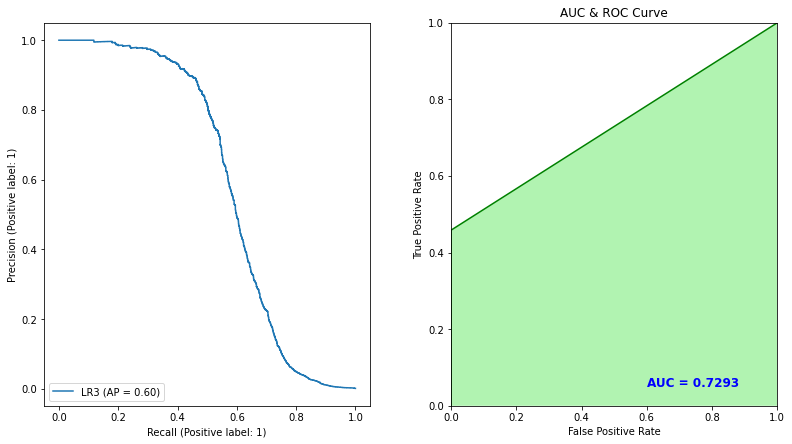

In [ ]:
plot_results(LR3_pipeline, X_test_new, Y_test_new, LR3_Y_pred, 'LR3')

#**Lasso Linear Regression Model**

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

Lasoo_pipeline = Pipeline([('transformer', preprocessing), ('estimator', Lasso())])
search = GridSearchCV(Lasoo_pipeline,
                      {'estimator__alpha':np.arange(0.1,10,0.1)},
                      cv = 5,
                      scoring="neg_mean_squared_error",
                      verbose=3
                     )

In [ ]:
search.fit(X_train,Y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .............estimator__alpha=0.1;, score=-0.001 total time=   4.5s
[CV 2/5] END .............estimator__alpha=0.1;, score=-0.001 total time=   3.6s
[CV 3/5] END .............estimator__alpha=0.1;, score=-0.001 total time=   3.5s
[CV 4/5] END .............estimator__alpha=0.1;, score=-0.001 total time=   3.5s
[CV 5/5] END .............estimator__alpha=0.1;, score=-0.001 total time=   3.6s
[CV 1/5] END .............estimator__alpha=0.2;, score=-0.001 total time=   3.6s
[CV 2/5] END .............estimator__alpha=0.2;, score=-0.001 total time=   3.7s
[CV 3/5] END .............estimator__alpha=0.2;, score=-0.001 total time=   3.7s
[CV 4/5] END .............estimator__alpha=0.2;, score=-0.001 total time=   3.6s
[CV 5/5] END .............estimator__alpha=0.2;, score=-0.001 total time=   3.7s
[CV 1/5] END estimator__alpha=0.30000000000000004;, score=-0.001 total time=   3.7s
[CV 2/5] END estimator__alpha=0.300000000000

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OrdinalEncoder(dtype=<class 'numpy.int32'>))]),
                                                                         ['type']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('robust_scalar',
                                                                                          RobustScaler())]),
                                                                         ['step',
                                            

In [ ]:
search.best_params_

{'estimator__alpha': 0.1}

In [ ]:
coefficients = search.best_estimator_.named_steps['estimator'].coef_

In [ ]:
np.abs(coefficients)

array([0., 0., 0., 0., 0., 0., 0., 0.])

**Next step is trying to implement models that can map non-linear relationships**

# **KNN Classifier**

In [ ]:
from sklearn.model_selection import GridSearchCV
'''from sklearn.neighbors import KNeighborsClassifier


params = {
    'knn__n_neighbors': range(1, 15, 2),
}

pipeline = Pipeline([('transformer', column_trans), ('knn', KNeighborsClassifier())]) 
grid_pipeline = GridSearchCV(pipeline, params, scoring='f1_macro')

grid_pipeline.fit(X_train,Y_train)'''

"from sklearn.neighbors import KNeighborsClassifier\n\n\nparams = {\n    'knn__n_neighbors': range(1, 15, 2),\n}\n\npipeline = Pipeline([('transformer', column_trans), ('knn', KNeighborsClassifier())]) \ngrid_pipeline = GridSearchCV(pipeline, params, scoring='f1_macro')\n\ngrid_pipeline.fit(X_train,Y_train)"

In [ ]:
'''grid_pipeline.best_params_'''

'grid_pipeline.best_params_'

**Optimal value of KNN neighbors parameter is 3 based on macro f1 metric (since the dataset is unbalanced).** 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
cvfolds = KFold(n_splits=5)
knn_pipeline = Pipeline([('transformer', preprocessing), ('estimator', KNeighborsClassifier(n_neighbors=3))])
knn_scores = cross_validate(knn_pipeline.fit(X_train, Y_train), X_train, Y_train, cv = cvfolds,\
                            scoring=('f1_macro', 'accuracy', 'f1_micro', 'recall', 'precision'),\
                            return_train_score=True, n_jobs=-1)
knn_scores

{'fit_time': array([76.82125187, 77.58844209, 37.25533986, 37.00684857, 33.38489413]),
 'score_time': array([734.32990956, 649.4794991 , 286.5348804 , 336.95489836,
        355.33100247]),
 'test_f1_macro': array([0.8952367 , 0.90401828, 0.90654956, 0.90423159, 0.90055902]),
 'train_f1_macro': array([0.93388877, 0.93127699, 0.93182222, 0.93292437, 0.93178543]),
 'test_accuracy': array([0.99951278, 0.99953537, 0.99955404, 0.99955011, 0.99953734]),
 'train_accuracy': array([0.99968321, 0.9996751 , 0.99967731, 0.99967977, 0.99967363]),
 'test_f1_micro': array([0.99951278, 0.99953537, 0.99955404, 0.99955011, 0.99953734]),
 'train_f1_micro': array([0.99968321, 0.9996751 , 0.99967731, 0.99967977, 0.99967363]),
 'test_recall': array([0.71690895, 0.73797187, 0.73971578, 0.742901  , 0.73359073]),
 'train_recall': array([0.80192963, 0.79301793, 0.79280822, 0.79659735, 0.79501699]),
 'test_precision': array([0.88146754, 0.89336918, 0.90319635, 0.8872594 , 0.88289963]),
 'train_precision': array([

In [ ]:
knn_Y_pred = knn_pipeline.predict(X_test)

Precision: 0.9122 --- Recall: 0.7500




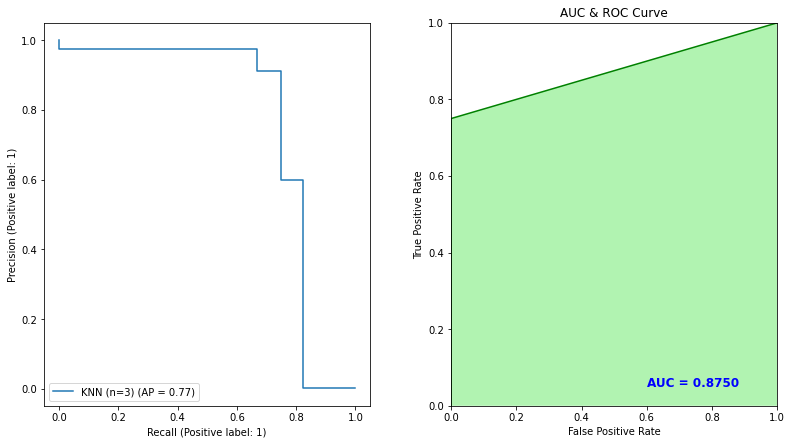

In [ ]:
plot_results(knn_pipeline, X_test, Y_test, knn_Y_pred, 'KNN (n=3)')

**KNN with borderline SMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
borderline_SMOTE = BorderlineSMOTE()
estimator =  KNeighborsClassifier(n_neighbors=3)

In [ ]:
borderline_SMOTE_pipeline =  Pipeline([('transformer', preprocessing),('borderline_oversampling', borderline_SMOTE), ('estimator', estimator)])

In [ ]:
cvfolds = KFold(n_splits=5)
knn_scores_SMOTE = cross_validate(borderline_SMOTE_pipeline.fit(X_train, Y_train), X_train, Y_train, cv = cvfolds\
                             , scoring=('f1_macro', 'accuracy', 'f1_micro', 'recall', 'precision'), return_train_score=True, n_jobs=-1)
knn_scores_SMOTE

{'fit_time': array([81.32383347, 79.31658435, 87.82237577, 91.98291874, 86.5791657 ]),
 'score_time': array([196.34152961, 222.6551702 , 169.76597238, 242.18133402,
        231.2653482 ]),
 'test_f1_macro': array([0.83692566, 0.83958931, 0.85271367, 0.83931052, 0.83779228]),
 'train_f1_macro': array([0.91171792, 0.90835231, 0.90696886, 0.91022857, 0.90955127]),
 'test_accuracy': array([0.999001  , 0.99896957, 0.99909137, 0.99898823, 0.99898725]),
 'train_accuracy': array([0.99948036, 0.99945777, 0.99944918, 0.99946637, 0.99946416]),
 'test_f1_micro': array([0.999001  , 0.99896957, 0.99909137, 0.99898823, 0.99898725]),
 'train_f1_micro': array([0.99948036, 0.99945777, 0.99944918, 0.99946637, 0.99946416]),
 'test_recall': array([0.80566182, 0.8238342 , 0.8302169 , 0.83653108, 0.83088803]),
 'train_recall': array([0.93511162, 0.9400992 , 0.93512177, 0.94026465, 0.93412609]),
 'test_precision': array([0.57984581, 0.57848233, 0.61393805, 0.5715784 , 0.56991525]),
 'train_precision': array([

In [ ]:
knn_scores_SMOTE_pred = borderline_SMOTE_pipeline.predict(X_test)

Precision: 0.5961 --- Recall: 0.8290




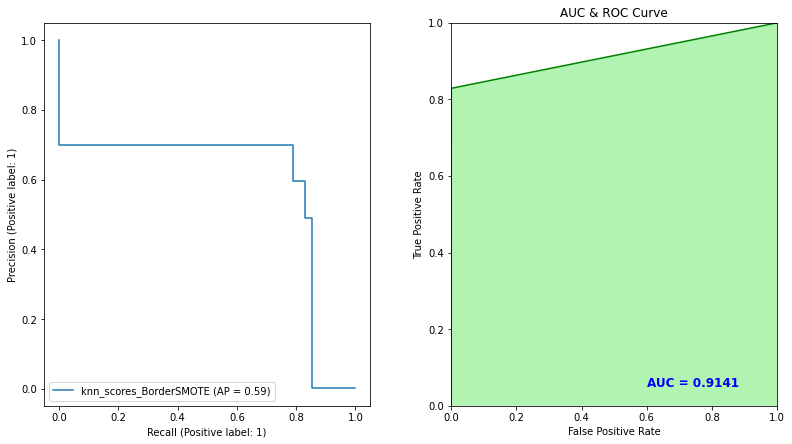

In [ ]:
plot_results(borderline_SMOTE_pipeline, X_test, Y_test, knn_scores_SMOTE_pred, 'knn_scores_BorderSMOTE')

# **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

'''param_grid = {
    'rfc__n_estimators': [10, 100, 200, 300, 1000]
}
pipeline = Pipeline([('transformer', column_trans), ('rfc', RandomForestClassifier())])

clf = GridSearchCV(pipeline, param_grid, scoring='f1_macro')
 
# Fit and tune model
clf.fit(X_train, Y_train)'''

"param_grid = {\n    'rfc__n_estimators': [10, 100, 200, 300, 1000]\n}\npipeline = Pipeline([('transformer', column_trans), ('rfc', RandomForestClassifier())])\n\nclf = GridSearchCV(pipeline, param_grid, scoring='f1_macro')\n \n# Fit and tune model\nclf.fit(X_train, Y_train)"

In [ ]:
'''clf.best_params_'''

'clf.best_params_'

In [ ]:
rfc_pipeline = Pipeline([('transformer', preprocessing),\
                         ('estimator', RandomForestClassifier(min_samples_leaf=15))])
cvfolds = KFold(n_splits=5)
rfc_scores = cross_validate(rfc_pipeline.fit(X_train, Y_train), X_train, Y_train, cv = cvfolds,\
                            scoring=('f1_macro', 'accuracy', 'f1_micro', 'recall', 'precision'),\
                            return_train_score=True, return_estimator =True, n_jobs=-1)
rfc_scores

{'fit_time': array([ 948.33068419,  927.74604654, 1190.13804102, 1070.48444057,
         852.95799351]),
 'score_time': array([12.66988325, 15.14046311, 12.98345327, 13.14344049,  9.53232813]),
 'estimator': [Pipeline(steps=[('transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('pipeline-1',
                                                    Pipeline(steps=[('cat_encoder',
                                                                     OrdinalEncoder(dtype=<class 'numpy.int64'>))]),
                                                    ['type']),
                                                   ('pipeline-2',
                                                    Pipeline(steps=[('robust_scalar',
                                                                     RobustScaler())]),
                                                    ['step', 'isFlaggedFraud',
                                                

In [ ]:
rfc_Y_pred = rfc_pipeline.predict(X_test)

Precision: 0.9887 --- Recall: 0.7549




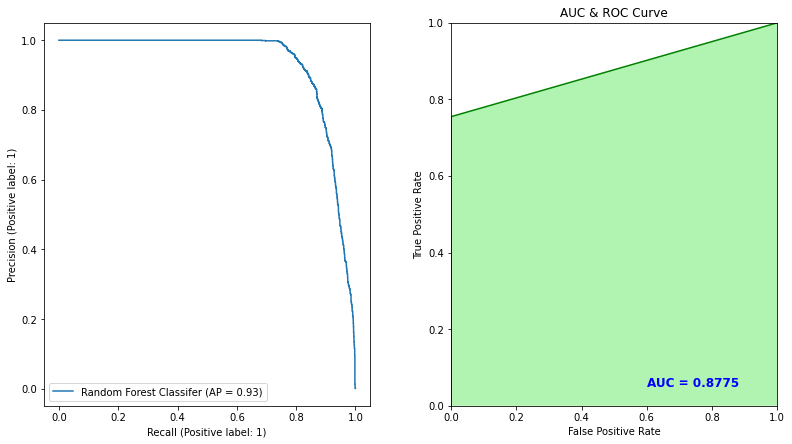

In [ ]:
plot_results(rfc_pipeline, X_test, Y_test, rfc_Y_pred, 'Random Forest Classifer')

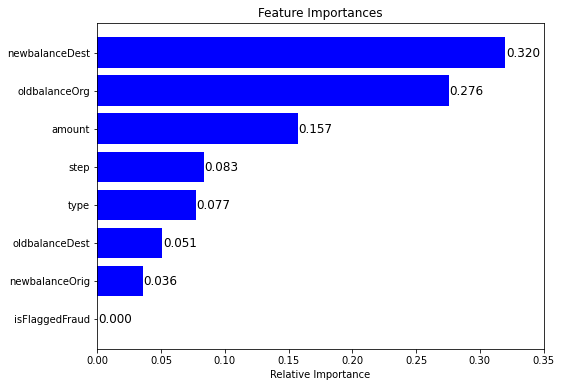

In [ ]:
#Plot RF feature importance map
features = X.columns
feature_importance_list = rfc_pipeline['estimator'].feature_importances_
indices = np.argsort(feature_importance_list)
plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance_list[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.xlim(0, 0.35)
# add the annotations
for y, x in zip(feature_importance_list[indices], np.arange(len(features))):
    plt.annotate('{:.3f}'.format(y), xy=(y+0.014, x), ha='center', va='center', size=12)
plt.show()

**newbalanceDest, oldbalanceOrg, amount are major features RFC relied on to make prediction decesion.**

**Tune thereshold for getting higher recall rate**

In [ ]:
cutoff_threshold_RFC =0.01  #new threshold

In [ ]:
predicted_proba_RFC = rfc_pipeline.predict_proba(X_test)

In [ ]:
predictions_RFC = [1 if i >= cutoff_threshold_RFC else 0 for i in predicted_proba_RFC[:, -1]]

Precision: 0.1726 --- Recall: 0.9938




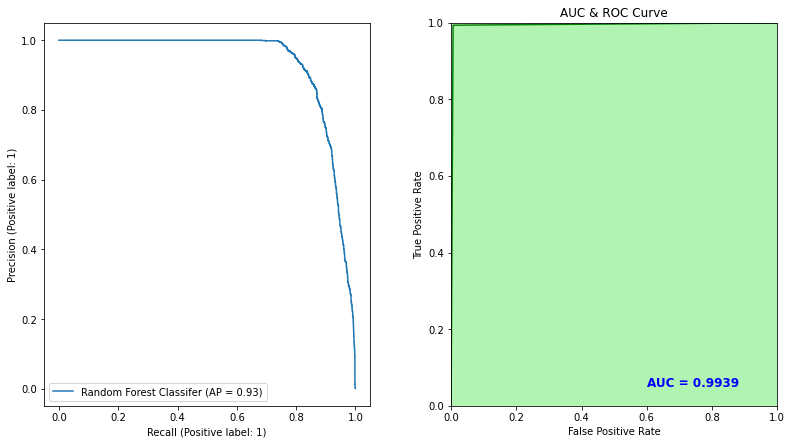

In [ ]:
plot_results(rfc_pipeline, X_test, Y_test, predictions_RFC, 'Random Forest Classifer')

# **eXtreme Gradient Boosting Classifier**

In [ ]:
#XGB Classifier
from xgboost import XGBClassifier

xgbc_pipeline = Pipeline([('transformer', preprocessing), ('estimator', XGBClassifier())])
cvfolds = KFold(n_splits=5)
xgbc_scores = cross_validate(xgbc_pipeline.fit(X_train, Y_train), X_train, Y_train, cv = cvfolds,\
                             scoring=('f1_macro', 'accuracy', 'f1_micro', 'recall', 'precision'),\
                             return_train_score=True, n_jobs=-1)
xgbc_scores

[09:10:27] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


{'fit_time': array([434.21532393, 412.59081721, 483.34494543, 482.15778065,
        287.26923084]),
 'score_time': array([5.12638664, 4.72442722, 4.93030262, 5.05646586, 3.21843362]),
 'test_f1_macro': array([0.91357503, 0.90635882, 0.91081672, 0.90697366, 0.91325013]),
 'train_f1_macro': array([0.91397192, 0.91140547, 0.90686757, 0.90875882, 0.91207353]),
 'test_accuracy': array([0.99961789, 0.99957368, 0.99959922, 0.99959235, 0.99961985]),
 'train_accuracy': array([0.9996142 , 0.99960855, 0.99958964, 0.99959382, 0.99960733]),
 'test_f1_micro': array([0.99961789, 0.99957368, 0.99959922, 0.99959235, 0.99961985]),
 'train_f1_micro': array([0.9996142 , 0.99960855, 0.99958964, 0.99959382, 0.99960733]),
 'test_recall': array([0.7130834 , 0.69800148, 0.70381451, 0.69762087, 0.71274131]),
 'train_recall': array([0.71604238, 0.70698207, 0.69539574, 0.70132325, 0.70819177]),
 'test_precision': array([0.98520085, 0.97316821, 0.98740818, 0.97741935, 0.98400853]),
 'train_precision': array([0.981

In [ ]:
xgbc_Y_pred = xgbc_pipeline.predict(X_test)

Precision: 0.9829 --- Recall: 0.6741




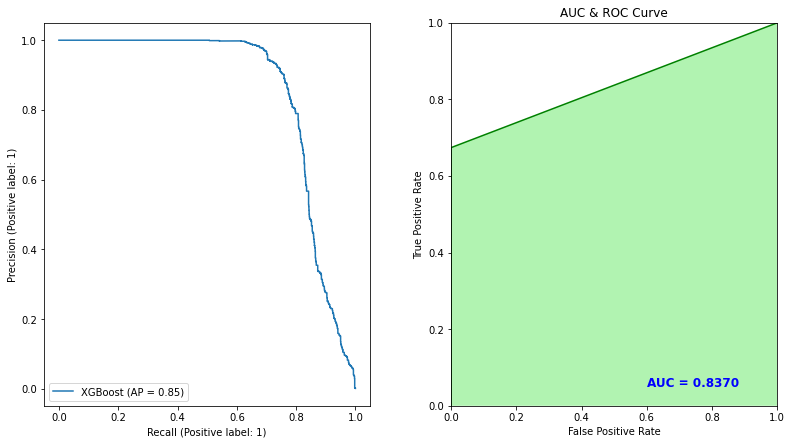

In [ ]:
plot_results(xgbc_pipeline, X_test, Y_test, xgbc_Y_pred, 'XGBoost')

**- The best classifier among all classifiers chosen is Random Forest Classifier. This is based on both Precesion-Recall (PR) curve and AUC score as shown in this notebook.**

**- Tuning min_samples_leaf parameter of Ranodm Forest Classifier has key impact on model generalisability on validation and testing samples and by which higher metrics achieved by the classifier.**

**Trying implementing xGboost with SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='not majority', random_state=42)

In [ ]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
estimator = XGBClassifier()
SMOTE_pipeline =  Pipeline([('transformer', preprocessing),('oversampling', sm)\
                            , ('estimator', estimator)])
cvfolds = KFold(n_splits=5)
xgbc_scores = cross_validate(SMOTE_pipeline.fit(X_train, Y_train), X_train,\
                             Y_train, cv = cvfolds, scoring=('f1_macro',\
                             'accuracy', 'f1_micro', 'recall', 'precision'),\
                             return_train_score=True)
xgbc_scores

[08:11:48] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[08:41:53] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[09:17:03] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[09:50:52] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:27:00] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (e

{'fit_time': array([2084.15568423, 2001.67183542, 2139.76149845, 2016.17402768,
        2037.46336889]),
 'score_time': array([5.56567812, 5.83696485, 5.49638128, 5.53842807, 5.31495333]),
 'test_f1_macro': array([0.56119899, 0.56151577, 0.5610826 , 0.56100227, 0.55976285]),
 'train_f1_macro': array([0.5624124 , 0.5598779 , 0.56020611, 0.5614726 , 0.56075108]),
 'test_accuracy': array([0.9831241 , 0.98262115, 0.98265553, 0.98308185, 0.98278225]),
 'train_accuracy': array([0.98322133, 0.98265136, 0.98271447, 0.98293991, 0.98273166]),
 'test_f1_micro': array([0.9831241 , 0.98262115, 0.98265553, 0.98308185, 0.98278225]),
 'train_f1_micro': array([0.98322133, 0.98265136, 0.98271447, 0.98293991, 0.98273166]),
 'test_recall': array([0.99005356, 0.99407846, 0.9947644 , 0.9923254 , 0.9953668 ]),
 'train_recall': array([0.99394627, 0.99370469, 0.99296043, 0.99470699, 0.99358248]),
 'test_precision': array([0.07009371, 0.07058391, 0.07007376, 0.06986923, 0.06852374]),
 'train_precision': array([

In [ ]:
smote_xgbc_Y_pred = SMOTE_pipeline.predict(X_test)

Precision: 0.0691 --- Recall: 0.9957




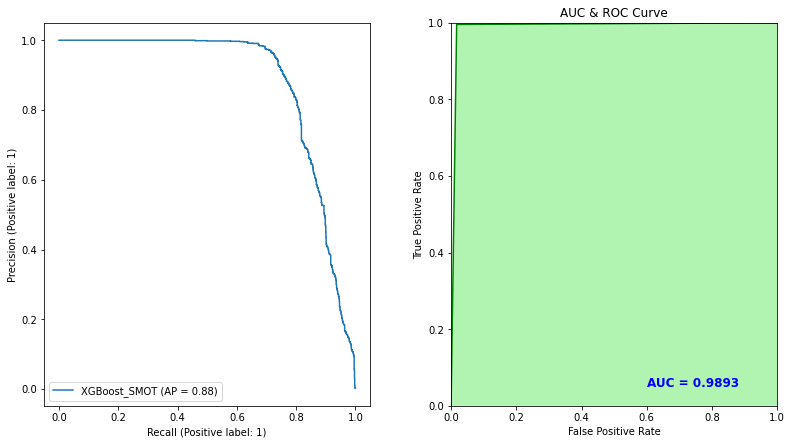

In [ ]:
plot_results(SMOTE_pipeline, X_test, Y_test, smote_xgbc_Y_pred, 'XGBoost_SMOT')

In [ ]:
SMOTE_pipeline.named_steps['oversampling'].sampling_strategy_

OrderedDict([(1, 5076910)])

**SMOTE sampler generated 5,076,910 synthetic examples to sample from for the targeted class (1 in this case)**

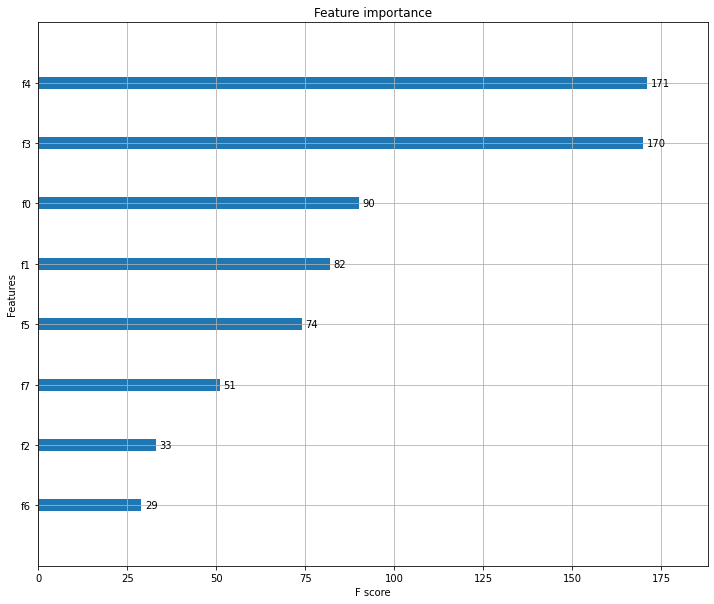

In [ ]:
# Plot Feature Importance for xgboost
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 10))
plot_importance(SMOTE_pipeline.named_steps['estimator'], ax=ax, importance_type='weight')

**XGBoost classifier relies most on 'oldbalanceOrg'(f4),  'amount'(f3) on making the prediction then 'type'(f0), step(f1)'' and 'newbalanceOrig'(f5). The numbering follows the colomn index of input matrix after preprocessing**

**Next, Tweaking the theroshold to throw some balance between Precision and Recall (default threshold value = 0.5)**

In [ ]:
cutoff_threshold =0.80  #new threshold

In [ ]:
predicted_proba = SMOTE_pipeline.predict_proba(X_test)

In [ ]:
predictions = [1 if i >= cutoff_threshold else 0 for i in predicted_proba[:, -1]]

Precision: 0.2074 --- Recall: 0.9537




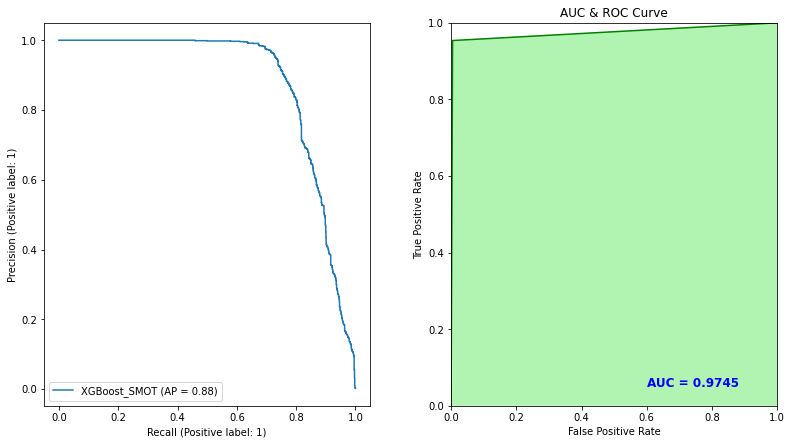

In [ ]:
plot_results(SMOTE_pipeline, X_test, Y_test, predictions, 'XGBoost_SMOTE')